In [1]:
import numpy as np
import pandas as pd
import multiprocessing as mlp
from multiprocessing import Pool
from functools import partial
import pickle as pkl
import math
import cmath

# Null Steering Beamforming (NSB) Algorithm

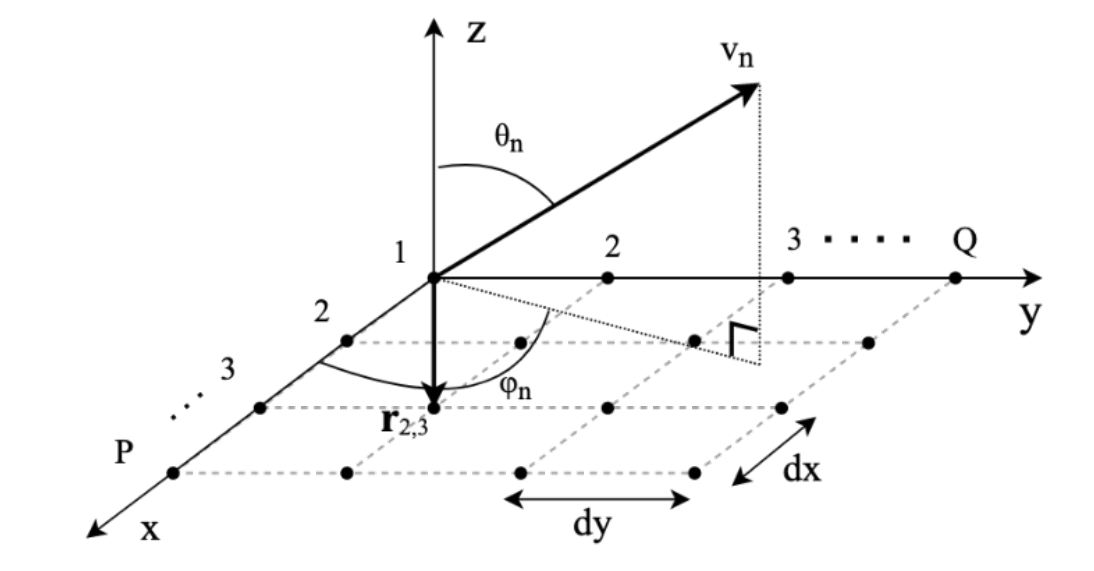

In [2]:
def find_position_vector(polar, azimuth):
    z = np.cos(polar*np.pi/180)
    x = np.sin(polar*np.pi/180)*np.cos(azimuth*np.pi/180)
    y = np.sin(polar*np.pi/180)*np.sin(azimuth*np.pi/180)
    return [x,y,z] #shape: (3,)

def find_steering_vector(wavelength, position, planar_antenna_shape):
    (P,Q) = planar_antenna_shape
    beta = (2*np.pi)/wavelength
    steering_vector = []
    for q in range(Q): # locating anatenas as (y,x)
        for p in range(P):
            r = [p*wavelength/2, q*wavelength/2, 0] #distance between each antena is taken as wavelenght of the signals
            steering_vector.append(np.exp(complex(0,beta*np.dot(r,position))))
    return steering_vector #shape: (PQ,)

def find_steering_matrix(wavelength, pos_angles, planar_antenna_shape):
    steering_matrix = []
    for angle in pos_angles:
        position = find_position_vector(angle[0], angle[1])
        steering_vector = find_steering_vector(wavelength, position, planar_antenna_shape)
        steering_matrix.append(steering_vector)
    steering_matrix = np.array(steering_matrix).T
    return steering_matrix #shape: (PQ, N)


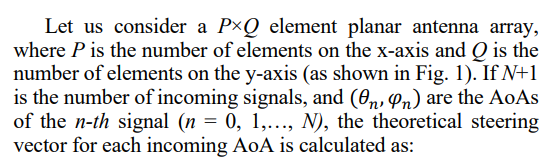

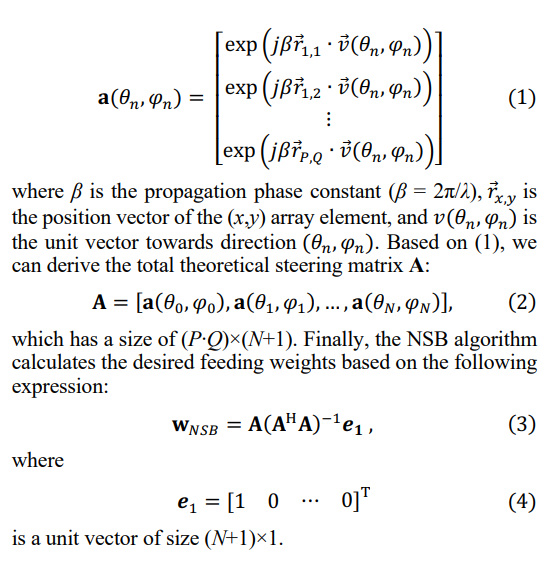

### testing NSB algorithm considering three incoming signals directions

In [3]:
# shape of 2d planar reciving atena array
P,Q = 2, 2
planar_antenna_shape = (P,Q)
print(f'shape of the receiving antena array : \nP: {P}\nQ: {Q}')
wavelength = 1 # in meters
beta = (2*np.pi)/wavelength

# all angles need to be in degree
polar = 30
azimuth = 10
position = find_position_vector(polar, azimuth)
print(f'\nshape of postion vector: {np.shape(position)}\nposition vector: \n{position}')

steering_vector = find_steering_vector(wavelength, position, planar_antenna_shape)
print(f'\nshape of steering vector: {np.shape(steering_vector)}\nsteering vector: \n{steering_vector}')

# position angles for all RIS elements
# pos_angles = [[polar1, azimuth1], [polar2, azimuth2], ... ]

pos_angles = [[30,45], [45,60], [0,90]]
steering_matrix = find_steering_matrix(wavelength, pos_angles, planar_antenna_shape)
print(f'\nshape of steering matrix: {np.shape(steering_matrix)}\nsteering matrix: \n{steering_matrix}')

e1 = np.zeros(len(pos_angles),)
e1[0] = 1.0
e1 = e1[np.newaxis].T # shape: (N,1)

A = steering_matrix.copy()
# w = A.dot(np.linalg.inv((np.dot(A.T, A)))).dot(e1)
w = A.dot(np.linalg.inv((np.dot(np.conj(A).T, A)))).dot(e1)
print(f'\nshape of w: {np.shape(w)}\nw: \n{w}') # shape: (PQ,1)

shape of the receiving antena array : 
P: 2
Q: 2

shape of postion vector: (3,)
position vector: 
[0.49240387650610395, 0.08682408883346515, 0.8660254037844387]

shape of steering vector: (4,)
steering vector: 
[(1+0j), (0.02386166079628459+0.9997152700364454j), (0.9630294530174716+0.2693961258460661j), (-0.24633993855223776+0.969183488651184j)]

shape of steering matrix: (4, 3)
steering matrix: 
[[ 1.        +0.j          1.        +0.j          1.        +0.j        ]
 [ 0.44401584+0.89601894j  0.44401584+0.89601894j  1.        +0.j        ]
 [ 0.44401584+0.89601894j -0.34574104+0.93832997j  1.        +0.j        ]
 [-0.60569987+0.7956932j  -0.99427592+0.10684285j  1.        +0.j        ]]

shape of w: (4, 1)
w: 
[[ 0.69064712-0.12947398j]
 [-1.24124206+0.4023174j ]
 [ 1.07194137-0.74396427j]
 [-0.52134644+0.47112085j]]


In [4]:
%%time
pos_angles = [[30,45], [45,60], [0,90]]
def nsb(P, Q, wavelength, pos_angles):
    e1 = np.zeros(len(pos_angles),)
    e1[0] = 1.0
    e1 = e1[np.newaxis].T # shape: (N,1)

    A = find_steering_matrix(wavelength, pos_angles, (P,Q))
    w = A.dot(np.linalg.inv((np.dot(np.conj(A).T, A)))).dot(e1)
#     w = A.dot(np.linalg.inv((np.dot(A.T, A)))).dot(e1)
    return w

nsb(2,2,1,pos_angles).ravel()[0].real

CPU times: user 343 µs, sys: 106 µs, total: 449 µs
Wall time: 455 µs


0.6906471249549864

# Dataset Production

In [6]:
%%time
count = 100 # prefer to keep count as multiple of 7 
polar_count = int(count/7)
azimuth_count = int(6*count/7)

ploar_limit = [0,60]
azimuth_limit = [0,360]

polars = np.linspace(ploar_limit[0], ploar_limit[1], polar_count)
azimuths = np.linspace(azimuth_limit[0], azimuth_limit[1], azimuth_count)
print(f'No. of polar angles: {polars.shape[0]}\nNo. of azimuths angles: {azimuths.shape[0]}\n')

angles = np.array(np.meshgrid(polars, azimuths)).T.reshape(-1,2)
data1 = pd.DataFrame(angles, columns=['polar1', 'azimuth1'])
data1[['x1','y1','z1']] = list(map(lambda x: find_position_vector(x[0], x[1]), angles))
print('data1 shape:', data1.shape)
# data['angles'] = angles
data1.info()

No. of polar angles: 14
No. of azimuths angles: 85

data1 shape: (1190, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   polar1    1190 non-null   float64
 1   azimuth1  1190 non-null   float64
 2   x1        1190 non-null   float64
 3   y1        1190 non-null   float64
 4   z1        1190 non-null   float64
dtypes: float64(5)
memory usage: 46.6 KB
CPU times: user 21.1 ms, sys: 1.06 ms, total: 22.2 ms
Wall time: 23.1 ms


In [13]:
# data1.to_csv('./first_incoming_signal_df.csv', index=False)
first_incoming_signal_df = pd.read_csv('./first_incoming_signal_df.csv')

In [8]:
def find_position_angles(unit_vector):
    polar_angle = (np.arccos(unit_vector[2])*180)/np.pi
    azimuthal_angle = (np.arctan2(unit_vector[1],unit_vector[0])*180)/np.pi

    return [polar_angle, azimuthal_angle]

def generate_vectors(specified_vector, 
                     num_vectors, 
                     lower_rotation_limit=6, 
                     return_angle=True, 
                     upper_rotation_limit=60):
    result = []
    rotation_angle = math.radians(lower_rotation_limit)
    upper_rotation_angle = math.radians(upper_rotation_limit)
    rotation_angles = np.linspace(rotation_angle, upper_rotation_angle, num=num_vectors)
    for i in range(num_vectors):
        np.random.seed()  # This will set a new random seed based on the system time
#         print(specified_vector)
        random_vector = np.random.rand(3)
        random_vector /= np.linalg.norm(random_vector)

        rotation_axis = np.cross(specified_vector, random_vector)
        rotation_axis /= np.linalg.norm(rotation_axis)

        # Performing the rotation using Rodrigues' rotation formula
        cos_theta = math.cos(rotation_angles[i])
        sin_theta = math.sin(rotation_angles[i])
        rotated_vector = specified_vector * cos_theta + \
                         np.cross(rotation_axis, specified_vector) * sin_theta + \
                         rotation_axis * np.dot(rotation_axis, specified_vector) * (1 - cos_theta)
        rotated_vector /= np.linalg.norm(rotated_vector)
        rotated_angle = find_position_angles(rotated_vector)
        if not return_angle:
            rotated_angle.extend(rotated_vector.tolist())
        result.append(rotated_angle)
            
    return result

Reference for **Rodrigues' Rotation**: https://youtu.be/C2wSyDIq9X8?si=W13Jibsu_ZG7mzdh
### testing randomness of second incoming signal direction generated

In [9]:
%%time
specified_vector = np.array([1, 1, 1])
lower_rotation_limit = 6
num_vectors = 10

print("\nSpecified Vector:", specified_vector)
print('Specified Angles:', find_position_angles(specified_vector))
print(f"\nGenerated {num_vectors} Random Vectors ({lower_rotation_limit} degrees away):")

vectors = generate_vectors(specified_vector, \
                           num_vectors, \
                           return_angle=False)
for vector in vectors:
    print(vector)

angle1 = vectors[np.random.randint(0,num_vectors)][0:2]
angle2 = vectors[np.random.randint(0,num_vectors)][0:2]
print(f'\nFor two random generated vectors\nvector1: {find_position_vector(angle1[0],angle1[1])}\nvector2: {find_position_vector(angle2[0],angle2[1])}')
print('- angle between vector1 and specified vector: ',(np.arccos(np.dot(find_position_vector(angle1[0], angle1[1]),[1,0,0]))*180)/np.pi)
print('- angle between vector2 and specified vector: ',(np.arccos(np.dot(find_position_vector(angle2[0], angle2[1]),[1,0,0]))*180)/np.pi)
print('- angle between vector1 and vector2: ',(np.arccos(np.dot(find_position_vector(angle1[0], angle1[1]), find_position_vector(angle2[0], angle2[1])))*180)/np.pi)


Specified Vector: [1 1 1]
Specified Angles: [0.0, 45.0]

Generated 10 Random Vectors (6 degrees away):
[50.22911136655662, 49.99837930432151, 0.49406877611886196, 0.5887744155785072, 0.6397192603201792]
[66.12345624493432, 49.36485500730033, 0.5955065541603881, 0.6939275200146227, 0.4047672675975369]
[54.40311447354511, 67.13382007513178, 0.315967097007398, 0.7492323391710203, 0.5820787709142456]
[65.43214559657125, 20.090577740400814, 0.8541289843758909, 0.3124075602515275, 0.41577060303332813]
[77.10597895761224, 67.14609047455197, 0.37858952269425983, 0.8982620812739228, 0.22314839603181716]
[81.93806101345022, 70.76656704551745, 0.32616202670165906, 0.9348529736619179, 0.1402435380804968]
[26.448719369178058, -6.532770373208179, 0.44250466975441927, -0.050673431864424856, 0.895333357218759]
[94.11362036419794, 15.748826927785604, 0.9599812621437104, 0.2707214991024429, -0.07173455413324027]
[107.914044791474, 54.887530027307335, 0.5472978598942679, 0.7783659318733668, -0.307589870

In [11]:
print('Number of CPU core we have:',mlp.cpu_count())

Number of CPU core we have: 10


### generating second signal direction based on first signal

In [14]:
%%time
num_vectors = 1000

# multiprocessing using 9 cores from CPU
with Pool(9) as pool:
    data2 = pool.map(partial(generate_vectors,
                            num_vectors=num_vectors,
                            return_angle=False), 
                            first_incoming_signal_df[['x1','y1','z1']].values)


# data = list(map(lambda x: generate_vectors(x,num_vectors), first_incoming_signal[['x1','y1','z1']].values))
print('Lenght of data2',len(data2))

Lneght of data2 1190
CPU times: user 3.11 s, sys: 290 ms, total: 3.4 s
Wall time: 35.2 s


In [15]:
%%time
# with open("second_incoming_signal.pkl", "wb") as file:
#     pkl.dump(data2, file)
    
with open("second_incoming_signal.pkl", "rb") as file:
    second_incoming_signal = pkl.load(file)

CPU times: user 8.36 s, sys: 621 ms, total: 8.98 s
Wall time: 9.2 s


In [16]:
%%time
signal_data_df = pd.DataFrame(columns=['polar2','azimuth2','x2','y2','z2','polar1','azimuth1','x1','y1','z1'])

for i,row in enumerate(first_incoming_signal_df.values.tolist()):
    tmp = pd.DataFrame()
    tmp[['polar2','azimuth2','x2','y2','z2']] = second_incoming_signal[i]
    tmp[['polar1','azimuth1','x1','y1','z1']] = row
    signal_data_df = pd.concat([signal_data_df,tmp], ignore_index=True)

signal_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190000 entries, 0 to 1189999
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   polar2    1190000 non-null  float64
 1   azimuth2  1190000 non-null  float64
 2   x2        1190000 non-null  float64
 3   y2        1190000 non-null  float64
 4   z2        1190000 non-null  float64
 5   polar1    1190000 non-null  float64
 6   azimuth1  1190000 non-null  float64
 7   x1        1190000 non-null  float64
 8   y1        1190000 non-null  float64
 9   z1        1190000 non-null  float64
dtypes: float64(10)
memory usage: 90.8 MB
CPU times: user 16.9 s, sys: 461 ms, total: 17.3 s
Wall time: 17.3 s


In [17]:
signal_data_df.tail()

polar2   azimuth2        x2        y2        z2  polar1  azimuth1  \
1189995  60.530283  70.047866  0.297085  0.818360  0.491963    60.0     360.0   
1189996  51.842044  73.488695  0.223473  0.753886  0.617832    60.0     360.0   
1189997  40.139778  77.651256  0.137867  0.629740  0.764474    60.0     360.0   
1189998  57.862016  71.322796  0.271166  0.802177  0.531960    60.0     360.0   
1189999  99.762030  46.751449  0.675244  0.717842 -0.169556    60.0     360.0   

               x1            y1   z1  
1189995  0.866025 -2.121150e-16  0.5  
1189996  0.866025 -2.121150e-16  0.5  
1189997  0.866025 -2.121150e-16  0.5  
1189998  0.866025 -2.121150e-16  0.5  
1189999  0.866025 -2.121150e-16  0.5

In [18]:
%%time
# signal_data_df.to_csv('./input_signal_data.csv',index=False)
signal_data_df = pd.read_csv('./input_signal_data.csv')

CPU times: user 14.7 s, sys: 271 ms, total: 15 s
Wall time: 15.4 s


### generating weight parameters for reciever atenas

In [19]:
%%time
P,Q = 8, 8 # shape of reciever
wavelength = 1 # in meters
atena_loc = []
for q in range(Q):
    for p in range(P):
        atena_loc.append(str((q+1,p+1)))

weight_data_df = pd.DataFrame()
weight_imag, weight_real = [], []

signal_angles = signal_data_df[['polar1', 'azimuth1', 'polar2', 'azimuth2']].values #.tolist()

def arrange_weights(angles, P, Q, wavelength, weight_imag, weight_real):
    weight = nsb(P, Q, wavelength, [[angles[0],angles[1]],[angles[2],angles[3]]]).ravel().copy()
    return [np.imag(weight), np.real(weight)]
    
# multiprocessing using 9 cores from CPU
with Pool(8) as pool:
    data = pool.map(partial(arrange_weights,
                             P=P, 
                             Q=Q, 
                             wavelength=wavelength,
                             weight_imag = weight_imag,
                             weight_real = weight_real), 
                     signal_angles)

CPU times: user 13.6 s, sys: 3.78 s, total: 17.4 s
Wall time: 1min 58s


In [2]:
%%time
# with open("receiver_weight_parameters.pkl", "wb") as file:
#     pkl.dump(data, file)
    
with open("receiver_weight_parameters.pkl", "rb") as file:
    data = pkl.load(file)

CPU times: user 5.32 s, sys: 2.44 s, total: 7.76 s
Wall time: 10.3 s


In [6]:
%%time
weight_data_df = pd.DataFrame()
atena_loc = []
P,Q = 8, 8 # shape of reciever
wavelength = 1 # in meters
for q in range(Q):
    for p in range(P):
        atena_loc.append(str((q+1,p+1)))

weight_data_df[list(map(lambda x: x+'-imag', atena_loc))] = list(map(lambda x: x[0], data))
weight_data_df[list(map(lambda x: x+'-real', atena_loc))] = list(map(lambda x: x[1], data))
weight_data_df.info()

<timed exec>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190000 entries, 0 to 1189999
Columns: 128 entries, (1, 1)-imag to (8, 8)-real
dtypes: float64(128)
memory usage: 1.1 GB
CPU times: user 59.7 s, sys: 7 s, total: 1min 6s
Wall time: 1min 8s


In [7]:
weight_data_df.head()

(1, 1)-imag  (1, 2)-imag  (1, 3)-imag  (1, 4)-imag  (1, 5)-imag  \
0     0.026345     0.025879     0.023847     0.020374     0.015668   
1     0.024519     0.021481     0.016183     0.009183     0.001216   
2     0.024373     0.021817     0.016973     0.010349     0.002639   
3     0.024772     0.024333     0.022054     0.018107     0.012791   
4     0.024123     0.023923     0.023209     0.021997     0.020312   

   (1, 6)-imag  (1, 7)-imag  (1, 8)-imag  (2, 1)-imag  (2, 2)-imag  ...  \
0     0.010014     0.003755    -0.002731     0.026019     0.024171  ...   
1    -0.006878    -0.014249    -0.020121     0.024145     0.020656  ...   
2    -0.005347    -0.012772    -0.018858     0.023993     0.020861  ...   
3     0.006507    -0.000268    -0.007023     0.024660     0.022915  ...   
4     0.018190     0.015677     0.012827     0.023119     0.021862  ...   

   (7, 7)-real  (7, 8)-real  (8, 1)-real  (8, 2)-real  (8, 3)-real  \
0     0.024758     0.030977     0.009087     0.009214     0.010920   
1     0.019824     0.027187     0.019080     0.013432     0.009959   
2     0.020494     0.027854     0.017768     0.012578     0.009604   
3     0.024265     0.030869     0.010026     0.009014     0.009880   
4     0.022968     0.026274     0.012739     0.014834     0.017323   

   (8, 4)-real  (8, 5)-real  (8, 6)-real  (8, 7)-real  (8, 8)-real  
0     0.014102     0.018567     0.024046     0.030208     0.036678  
1     0.009029     0.010738     0.014907     0.021097     0.028657  
2     0.009160     0.011291     0.015774     0.022140     0.029719  
3     0.012558     0.016848     0.022422     0.028862     0.035678  
4     0.020153     0.023262     0.026585     0.030049     0.033580  

[5 rows x 128 columns]

In [8]:
%%time
weight_data_df.to_csv('./output_weight_parameters_data.csv',index=False)
# weight_data_df = pd.read_csv('./output_weight_parameters_data.csv')

CPU times: user 3min 30s, sys: 4.89 s, total: 3min 34s
Wall time: 3min 55s
